<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
C:\Users\somic\AppData\Local\Temp\ipykernel_26572\908550493.py:25: SyntaxWarning: invalid escape sequence '\m'
  model = YOLO("..\models\YOLO_v11\yolo_v11.pt").to(device)  # Use the Ultralytics YOLO class
C:\Users\somic\AppData\Local\Temp\ipykernel_26572\908550493.py:28: SyntaxWarning: invalid escape sequence '\m'
  checkpoint = torch.load("..\models\YOLO_v11\yolo_v11.pt", map_location=device)


Step 0, Loss: -0.5085748434066772, Predicted label: traffic
Step 50, Loss: -0.9863646030426025, Predicted label: traffic
Step 100, Loss: -0.9948394894599915, Predicted label: traffic
Step 150, Loss: -0.9972212314605713, Predicted label: traffic
Step 200, Loss: -0.9980272650718689, Predicted label: traffic
Target class matched for 5 consecutive steps. Stopping training.


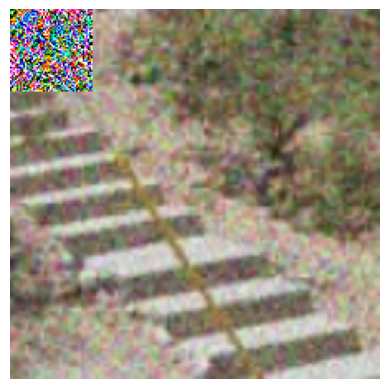

In [67]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO


import torch
import torchvision
from datetime import datetime

# Define the model architecture (this should match the model used to create the `.pt` file)
# Replace this with the appropriate YOLOv11 model class if you have it.
# For example, if you have a YOLO model definition:
from ultralytics import YOLO  # For YOLO v11, but if you're not using Ultralytics, replace this with your own model definition.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture (For YOLOv11 or similar, you would load it like this)
model = YOLO("..\models\YOLO_v11\yolo_v11.pt").to(device)  # Use the Ultralytics YOLO class

# Load the saved state dict
checkpoint = torch.load("..\models\YOLO_v11\yolo_v11.pt", map_location=device)

# If the saved file is only the model weights (state_dict), you need to load them manually
# If the checkpoint contains 'state_dict', load it like this
model = checkpoint['model'].to(device).to(torch.float32)  # Load the model to the device and set the datatype to float32

# Now set the model in evaluation mode
model.eval()



# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# # model = YOLO("..\models\YOLO_v11\yolo_v11.pt").to(device)

# model = torch.load("..\models\YOLO_v11\yolo_v11.pt")
# model.eval()


# Download ImageNet class labels
# url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
# with urllib.request.urlopen(url) as response:
#     labels = json.loads(response.read().decode())


# Define the class labels for the YOLO model
labels = ['bicycle', 'bridge', 'bus', 'car', 'chimney', 'crosswalk', 'hydrant', 'motorcycle', 'mountain', 'other', 'palm', 'traffic', 'stairs']


# Define transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load an example image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Overlay patch onto image without modifying the original image
def apply_patch_direct(image, patch, location):
    patched_image = image.clone()
    h, w = patch.shape[1:3]
    patched_image[:, :, location[0]:location[0]+h, location[1]:location[1]+w] = patch
    return patched_image

# Visualize the patched image
def visualize_image(image_tensor):
    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np.clip(image_np, 0, 1))
    plt.axis('off')
    plt.show()


def train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05):
    image = load_image(image_path)
    
    # Initialize random patch with the required size
    patch = torch.rand((3, *patch_size), requires_grad=True)
    optimizer = optim.Adam([patch], lr=lr)

    # Counter for consecutive steps where predicted label equals target class
    consecutive_count = 0
    max_consecutive = 5  # Number of consecutive steps to terminate on matching target class

    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply patch directly without altering the base image
        patched_image = apply_patch_direct(image, patch, (0, 0))  # Place at the top-left corner
        
        # Forward pass through the model
        output = model(patched_image)
        
        # Calculate loss to maximize the target class probability
        loss = -output[0][target_class]  # Negative because we want to maximize the target class probability
        loss.backward()
        
        # Update the patch
        optimizer.step()
        
        # Get the predicted label
        _, predicted_idx = torch.max(output, 1)
        predicted_label = predicted_idx.item()
        
        # # Check if the predicted label matches the target class
        # if predicted_label == target_class:
        #     consecutive_count += 1
        # else:
        #     consecutive_count = 0  # Reset the counter if it doesn't match
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            _, predicted_idx = torch.max(output, 1)
            predicted_label = labels[predicted_idx.item()]
            print(f"Step {step}, Loss: {loss.item()}, Predicted label: {predicted_label}")

            if predicted_idx.item() == target_class:
                consecutive_count += 1
            else:
                consecutive_count = 0  # Reset the counter if it doesn't match

            
            # If we have 5 consecutive steps where predicted label equals target class, stop training
            if consecutive_count >= max_consecutive:
                print(f"Target class matched for {max_consecutive} consecutive steps. Stopping training.")
                break

    return patch




# Example usage: Define the target class and train the patch on an example image
target_class = 11  # Replace with your desired target class index
image_path = "../assets/Stair_3.png"  # Replace with the path to your image
trained_patch = train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)


# Save the trained adversarial patch
torch.save(trained_patch, "adversarial_patch_direct.pt")

# Load image and apply the adversarial patch for evaluation
image = load_image(image_path)

# Original label
output = model(image)
_, original_idx = torch.max(output, 1)
original_label = labels[original_idx.item()]

patched_image = apply_patch_direct(image, trained_patch, (0, 0))  # Place the patch in the same position used during training

# Visualize the patched image
visualize_image(patched_image)

# Classify the patched image
output = model(patched_image)

# results = model.predict(patched_image, save=True, save_txt=True, save_conf=True, show_boxes=True, save_crop=True)
# print(results)
_, predicted_idx = torch.max(output, 1)
predicted_label = labels[predicted_idx.item()]

# Store the patched image
patched_image_np = patched_image.squeeze().permute(1, 2, 0).detach().cpu().numpy()
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.imsave(f"../../yolov11_breaker/sample_missclassifications/{original_label}_to_{predicted_label}_at_{timestamp}.png", np.clip(patched_image_np, 0, 1))



In [43]:
output = model(patched_image)
_, predicted_idx = torch.max(output, 1)
predicted_label = labels[predicted_idx.item()]

In [44]:
predicted_label

'car'

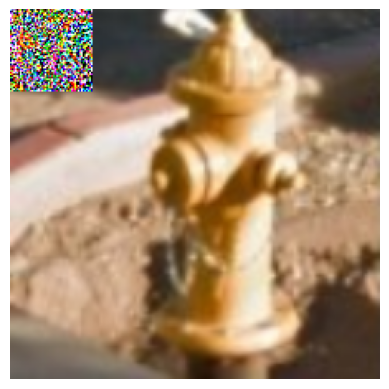

car


In [61]:
image_path = "../../yolov11_breaker/sample_missclassifications/hydrant_to_car.png" 
image = load_image(image_path)
output = model(image)

visualize_image(image)

_, predicted_idx = torch.max(output, 1)
predicted_label = labels[predicted_idx.item()]
print(predicted_label)

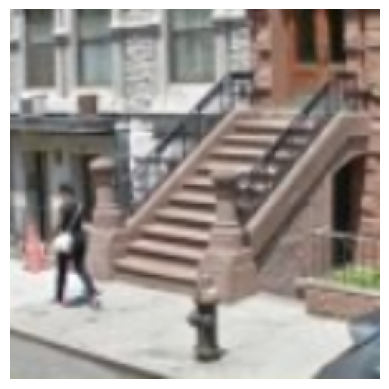

traffic


In [68]:
image_path = "../assets/Stair_1.png" 
image = load_image(image_path)
output = model(image)

visualize_image(image)

_, predicted_idx = torch.max(output, 1)
predicted_label = labels[predicted_idx.item()]
print(predicted_label)